In [1]:
import numpy as np
from numpy.testing import assert_allclose

from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc
assert PETSc.ScalarType == np.complex128, "Complex double precision seems to be needed."

import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import edrixs
from solvers import ed_1v1c_py, rixs_1v1c_py

from manybody_operator_csr import two_fermion_csr, four_fermion_csr

from scipy.sparse.linalg import aslinearoperator
from lanczos import lanczos_tridiagonal

# Run a calcuation using the regular python solver
The regular function `ed_1v1c_py` is modified to return various useful information

## required info
$H$ is `hmat` --- sparse initial state Hamiltonian

$\widetilde{H}$ is `hmat_int` --- sparse intermediate state Hamiltonian


## values for dense calculation and checks
$E_i$ is `eval_i_all` --- all initial state eignevalues

$\ket{i}$ is `evec_i_all` --- all initial state eignevectors

$E_n$ is `eval_n_all` --- all intermediate state eignevalues

$\ket{n}$ is `evec_n_all` --- all intermediate state eignevectors


Below `gs_list` provides a list of indices to use for the ground state. This always seemed like a bit of a strange decision. Much more natural would be to provide an integer defining the number of use. If this is set to `None`, the code could easily find the states that have non negligable population at the given `temperature`. I've changed the code to take `num_gs`.

To get started, we are computing one incident energy and one polarization. I'm unsure whether we should include this generalization at this point. I beleive polarization this just another repition of these methods. The incident energy direction is different because there are possible effciency savings here beyond just re-running the data see
[Phys. Rev. B 112, 115113 (2025)](https://doi.org/10.1103/gfdn-pyr2).

In [2]:
shell_name = ('d', 'p')
v_noccu = 8
slater = ([0.0, 12.234, 7.598],
          [0.0, 12.234, 7.598, 0.0, 7.721, 5.787, 3.291])

c_soc = 11.507
v_soc=(0.05, 0.09)

shell_level = (0, -886.5)
info_shell = edrixs.info_atomic_shell()

v_cfmat = edrixs.cf_cubic_d(1.07)

out = ed_1v1c_py(shell_name, shell_level=shell_level, c_soc=c_soc,
                 v_noccu=v_noccu, v_cfmat=v_cfmat, v_soc = v_soc,
                 slater=slater, csr=True)
eval_i_all, evec_i_all, eval_n_all, evec_n_all, trans_op, basis_i, basis_n, hmat, hmat_int, ntot, emat_i, emat_n, umat_i, umat_n = out
temperature = 300  # in K

ominc = [853]
eloss = np.arange(-1, 5, 0.01)

gamma_c = 0.5
gamma_f = 0.05
thin = np.deg2rad(30)
thout = np.deg2rad(30)
phi = 0
pol_type = [('linear', 0, 'linear', 0)] #, ('linear', 0, 'linear', np.pi/2)]
assert len(ominc) == 1, "Code implemented for 1 incident energy at the moment"
assert len(pol_type) == 1, "Code implemented for 1 polarization at the moment"

num_gs = 3
gs_list = range(num_gs)

rixs_map = rixs_1v1c_py(eval_i_all, eval_n_all, trans_op, ominc, eloss,
                 gamma_c=gamma_c, gamma_f=gamma_f, thin=thin, thout=thout, phi=phi,
                 pol_type=pol_type, gs_list=gs_list, temperature=temperature)
rixs = rixs_map.sum((-3, -1))

# Start Krylov implementation

Obtain a handful of the eigenvectors of the ground-state Hamiltonian 
$$
{\cal H} \ket{i} = E_i \ket{i}
$$

${\cal H}$ is built somewhat inefficiently right now. Desirable to replace this with a [perfect hashing method](https://doi.org/10.1016/j.cpc.2017.11.011), but this is somewhat separate, so we can leave this until later. 

The LOBPCG PETSc method is used. See [here](https://slepc.upv.es/release/manualpages/EPS/EPSLOBPCG.html), which links to a paper describing the method. 

The default Krylov-Schur seems not to work for reasons that aren't obvious to me.

In [3]:
tol = 1e-10
max_it = 1000
H = PETSc.Mat().createAIJ(size=hmat.shape, csr=(hmat.indptr, hmat.indices, hmat.data))
E = SLEPc.EPS().create()
E.setOperators(H)
E.setType(SLEPc.EPS.Type.LOBPCG)
E.setTolerances(tol=tol, max_it=max_it)

E.setProblemType(SLEPc.EPS.ProblemType.HEP)  # Hermitian eigenproblem
E.setDimensions(num_gs)
E.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_REAL)
E.solve()

nconv = E.getConverged()
assert nconv>=num_gs

eval_i = np.zeros(num_gs)
evec_i = [None]*num_gs
errors = np.zeros(num_gs)
vr = H.getVecLeft()
for ind in range(num_gs):
    k = E.getEigenpair(ind, vr)
    eval_i[ind] = k
    evec_i[ind] = vr.copy() # copy is crucial. 
    errors[ind] = E.computeError(ind, SLEPc.EPS.ErrorType.RELATIVE)

if np.any(errors >1e-6):
    raise Exception(f"Errors are {errors}")
np.testing.assert_allclose(eval_i_all[:num_gs], eval_i[:num_gs], atol=tol)

Generate the absorption and emission operators `Dk_ylm` and `Dkp_ylm` in single particle $Y^l_m$ basis.

In [4]:
Top_ylm = edrixs.get_trans_oper(shell_name[0] + shell_name[1])

ei, ef = edrixs.dipole_polvec_rixs(thin, thout, phi, pol_type[0][1], pol_type[0][3])
Dk_ylm = sum(T*i for T, i in zip(Top_ylm, ei))
Dkp_ylm = sum(T*i for T, i in zip(Top_ylm, ef))

Create the absoprtion operator ${\cal D}_{\boldsymbol{k},\hat{\epsilon}}$ in the fock basis `Dk` and equivalent emission operator ${\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}$ called `Dkp`.

In [5]:
v_norb = info_shell[shell_name[0]][1]
c_norb = info_shell[shell_name[1]][1]

tmp = np.zeros((ntot, ntot), dtype=complex)

tmp[0:v_norb, v_norb:ntot] = Dk_ylm
indptr, indices, data, nl, nr = two_fermion_csr(tmp, basis_n, basis_i)
Dk = PETSc.Mat().createAIJ(csr=(indptr, indices, data), size=(nl, nr))

tmp[0:v_norb, v_norb:ntot] = Dkp_ylm
indptr, indices, data, nl, nr = two_fermion_csr(tmp, basis_n, basis_i)
Dkp = PETSc.Mat().createAIJ(csr=(indptr, indices, data), size=(nl, nr)).hermitianTranspose()

Compute
$$
\ket{b_i} = {\cal D}_{\boldsymbol{k},\hat{\epsilon}} \ket{i}.
$$

Solve the following linear equation, involving the intermediate state Hamiltontian ${\cal \widetilde{H}}$ via sparse [MINRES](https://en.wikipedia.org/wiki/Minimal_residual_method) methods

$$
\hat{A} \ket{x_i} = \ket{b_i}
$$

where
$$
\hat{A} = \left({\cal \widetilde{H}} - E_i - \hbar\omega_{\boldsymbol{k}}+i\Gamma_c\right)
$$

Since $\hat{A}$ is not hermitian (explicit imaginary factors in diagonal) PETSc is using gmres as described [here](https://petsc.org/release/manualpages/KSP/KSPGMRES/). There might be better methods or the possibility of using preconditioners.

In [6]:
bvec = [Dk @ evec_i[i] for i in range(num_gs)]

Hint = PETSc.Mat().createAIJ(size=hmat_int.shape,
                             csr=(hmat_int.indptr, hmat_int.indices, hmat_int.data))
Hint.assemble()

A = Hint.duplicate(copy=True)
ksp = PETSc.KSP().create(Hint.getComm())
ksp.setType('gmres')
pc = ksp.getPC()
ksp.setTolerances(rtol=1e-12, max_it=50000)
ksp.setFromOptions()

xvec = [bvec[l].duplicate() for l in range(len(bvec))] # presume only one energy for now
for q in range(len(ominc)):
    for l in range(len(bvec)):
        alpha = -ominc[q] - eval_i[l] + 1j*gamma_c

        A.zeroEntries()
        A.axpy(1.0, Hint, structure=PETSc.Mat.Structure.SAME_NONZERO_PATTERN)
        A.shift(alpha)
        ksp.setOperators(A)

        b = bvec[l]
        x = xvec[l]
        x.zeroEntries()

        ksp.solve(b, x)
        if ksp.getConvergedReason() < 0:
            raise RuntimeError(f"Not converged: {ksp.getConvergedReason()}")
        xvec[l] = x.copy()

Apply emission operator

$$
\ket{F_i} = {\cal D}^\dagger_{\boldsymbol{k}^\prime,\hat{\epsilon}^\prime}  \ket{x_i}
$$

In [7]:
Fvec = [Dkp @ x for x in xvec]

* The spectrum can then be represented as

$$
I \propto -\sum_{i}e^{- E_{i}/(k_\mathrm{B}T)} \Im \bra{F_i} \frac{1}{{\cal H} - E_i - \hbar\omega_{\boldsymbol{q}}+i \Gamma} \ket{F_i}
$$

The continued fraction technique is then used to construct the spectrum. The ground state Hamiltonian $H$ (`hmat`) is represented in terms of an $m$ order Krylov subspace based on seed vector $\ket{F_i}$ (`Fvec`). The Krylov representation defines a set of poles that can be used to construct the spectrum 

In [8]:
poles_dict = {'npoles': [], 'eigval': [], 'norm': [],
              'alpha': [], 'beta': []}

for i in range(num_gs):
    alpha_i, beta_i, norm_i = lanczos_tridiagonal(H, Fvec[i], m=200)
    poles_dict['npoles'].append(len(alpha_i))
    poles_dict['eigval'].append(eval_i[i])
    poles_dict['norm'].append(norm_i)
    poles_dict['alpha'].append(alpha_i)
    poles_dict['beta'].append(beta_i)

rixs_Krylov = edrixs.get_spectra_from_poles(poles_dict, eloss, gamma_f, temperature)

# Calculate in Fortran

In [9]:
from mpi4py import MPI
comm = MPI.COMM_WORLD

eval_i, denmat = edrixs.ed_1v1c_fort(comm, shell_name, shell_level=shell_level,
                 v_soc=v_soc, c_soc=c_soc, v_noccu=v_noccu, slater=slater, v_cfmat=v_cfmat,
                 do_ed=True, ed_solver=2, neval=num_gs, nvector=num_gs, ncv=num_gs+2,
                 idump=True, maxiter=500, eigval_tol=1e-8, min_ndim=1000)

_, e_fortran = np.loadtxt('eigvals.dat', unpack=True)
np.testing.assert_allclose(eval_i_all[:num_gs], e_fortran, atol=tol)

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,  Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          0.0000000000        0.0000000000
     F2_vv :         12.2340000000       12.2340000000
     F4_vv :          7.5980000000        7.5980000000
     F0_vc :          0.0000000000        0.0000000000
     F2_vc :          0.0000000000        7.7210000000
     G1_vc :          0.0000000000        5.7870000000
     G3_vc :          0.0000000000        3.2910000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000

 --------------------------------------------
  fedrixs >>> ED begin ... 

  fedrixs >>> ndim_i:          45  is smaller than min_ndim:        1000
  fedrixs >>> set ed_solver = 0, use full-diagonalization !

     num_val_orbs:               10
     ed_solver:                   0
     neval:                       3
     nvector:                    

In [10]:
out = edrixs.rixs_1v1c_fort(comm, shell_name, ominc, eloss, gamma_c=gamma_c, gamma_f=gamma_f,
                      v_noccu=v_noccu, thin=thin, thout=thout, phi=phi, pol_type=pol_type,
                      num_gs=num_gs, temperature=temperature)

edrixs >>> Running RIXS ...

edrixs >>> Calculate RIXS for incident energy:  853
edrixs >>> Polarization:  0
  fedrixs >>> RIXS Begin ...

     num_val_orbs:               10
     num_core_orbs:               6
     ndim_i:                     45
     ndim_n:                     60
     ndim_f:                     45
     nhopp_i:                    22
     nhopp_n:                    32
     ncoul_i:                   340
     ncoul_n:                   932
     num_gs:                      3
     nkryl:                     200
     linsys_max:                500
     linsys_tol:           0.10E-07
     omega_in:           853.000000
     gamma_in              0.500000

  fedrixs >>> For initial state:             1
     Building transition operator for absorption process ...
     Done !

     Apply transition operator on the ground state to get intermediate state...
     Done !

     Building Hamiltonian for intermediate configuration ...
     Allocate memory for ham_csr ...
     Rea

In [11]:
rixs_fort = out[0].sum((0, 2))

Text(0, 0.5, 'I')

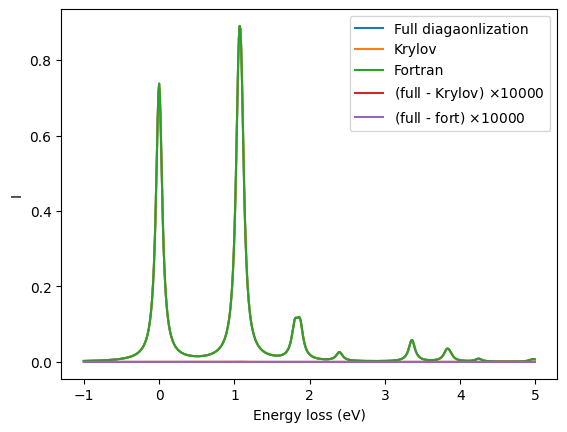

In [12]:
fig, ax = plt.subplots()

np.testing.assert_allclose(rixs, rixs_Krylov, rtol=1e-6, atol=1e-6)
np.testing.assert_allclose(rixs, rixs_fort, rtol=1e-6, atol=1e-6)

ax.plot(eloss, rixs, label='Full diagaonlization')
ax.plot(eloss, rixs_Krylov, label='Krylov')
ax.plot(eloss, rixs_fort, label='Fortran')
ax.plot(eloss, 10000*(rixs - rixs_Krylov), label=r'(full - Krylov) $\times10000$')
ax.plot(eloss, 10000*(rixs - rixs_fort), label=r'(full - fort) $\times10000$')

ax.legend()
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')